In [1]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img
from datetime import date

# my imports
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import volatility_estimator as ve

## Importing and processing data

In [14]:
#set overall parameters (list opf securities and window of days on which you compute the volatility on)

list_securities =  ['UPRO', 'TMF', 'IAU']  # ['SSO', 'UBT', 'UGL'] # ['UPRO', 'TMF', 'TYD']  # ['VTI', 'VGLT',  'IAU'] #['SPY', 'TLT', 'GLD'] #'VGLT', 'IAU']#['SSO', 'UBT', 'UGL'] # #'TYD'] #, 'DIG', 'UST'] #['SPY', 'TLT', 'GLD'] 'UTSL'] #DIG
window = 30 #days
title = 'x3 leverage'
estimator = 'stdv'
#start_date = pd.to_datetime('2007/01/03')
end_date = date.today() - pd.DateOffset(days=180)
# end_date = start_date + pd.DateOffset(days=1814) 
start_date = pd.to_datetime(end_date) - pd.DateOffset(days=1824) 

if estimator not in ['stdv', 'parkinson', 'satchell']:
    raise ValueError('estimator has to be one of : stdv, parkison, satchell')

In [47]:
#main

data = hep.create_dataframe(list_securities) #I can import this dataframe but it is preatty fast.
data['IAU'] = data['IAU'].replace([data['IAU'].max()], 34.599998)
#data['IAU'] =3* data['IAU']

if estimator == 'stdv':
    unique_name = 'stdv'
    for i in list_securities:
        unique_name += '_' + i
        
    df_strd_dev = ve.dataframe_strd_dev(data, window)
    df_strd_dev = ve.index_df(df_strd_dev, data, window)
    data_perc = hep.return_df(data)
    inv_volat_data = hep.df_inverse_volatility(data_perc, window)
    df_weighted = hep.df_wheighted(inv_volat_data)
    
if estimator == 'parkinson':
    unique_name = 'parkinson'
    for i in list_securities:
        unique_name += '_' + i

    data_h_l = ve.create_dataframe_high_low(list_securities)   
    #data_h_l = data_h_l[1135: 1135 + 1834]
    data_h_l = data_h_l.loc[start_date: end_date]
    df_volat = ve.compute_park_volatility(data_h_l, list_securities, window)
    data.dropna(inplace = True)
    #data = data[1135: 1135 + 1834]
    data = data[start_date: end_date]
    df_volat = ve.index_df(df_volat, data, window)
    df_inv_volat = df_volat.applymap(lambda x: 1/x)
    df_weighted = hep.df_wheighted(df_inv_volat)

if estimator == 'satchell':
    unique_name = 'satchell'
    for i in list_securities:
        unique_name += '_' + i
        
    data_ohlc = ve.create_dataframe_ohlc(list_securities)
    #data_holc = data_holc[1135: 1135 + 1834]
    data_ohlc = data_ohlc[start_date: end_date]
    df_satchell_volat = ve.compute_satchell_volatility(data_ohlc, list_securities, window)
    data.dropna(inplace = True)
    #data = data[1135: 1135 + 1834]
    data = data[start_date: end_date]
    df_satchell_volat = ve.index_df(df_satchell_volat, data, window-1)
    df_satchell_inv_volat = df_satchell_volat.applymap(lambda x: 1/x)
    df_weighted = hep.df_wheighted(df_satchell_inv_volat)
    
data_r = data.div(data.shift(1))-1
data_r['IAU'] = 3*data_r['IAU']
data_earnings = hep.df_earnings(df_weighted, data_r)
data_earnings.dropna(inplace = True)
    
data_earnings = data_earnings[start_date: end_date]

## Create and export plot for the report

#### Table of returns:

In [48]:
#param
figsize=(10, 5.5)
fontname = 'Arial'
annot_size=10
square = False
cbar = False
cmap = LinearSegmentedColormap.from_list('RedGreen', ['crimson', 'gold', 'lime'])
eoy = False
compounded = True

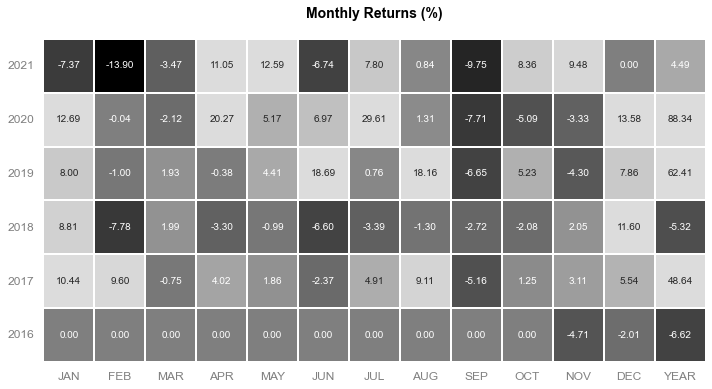

In [49]:
#crate the returns table plus the return over the year

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)
#yearly_returns = returns.div(100).add(1).cumprod(axis=1)['DEC'] - 1
#returns['YEAR'] = yearly_returns *100
#returns

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('../img/temp/table_montly_returns' + unique_name + '.png')
fig_table = fig 

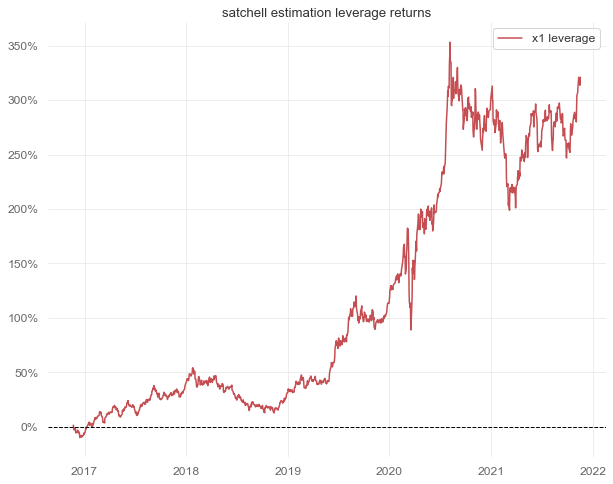

In [50]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('satchell estimation leverage returns')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(data_earnings['Tot']), lw=1.5, label='x1 leverage', color='r', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()
fig = ax.get_figure()
fig.set_size_inches(10,8)
#fig.savefig('../img/satchell_1x_leverage.png')

#### Distribution plot:

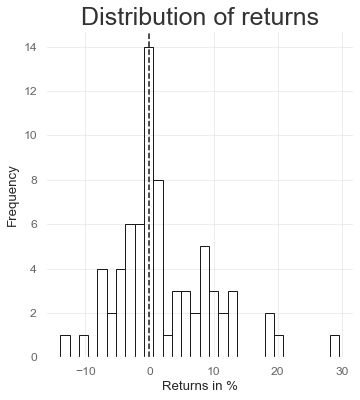

In [51]:
returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

series = pd.Series(dtype = 'float64')
for column in returns.columns:
    series = pd.concat([series,returns[column]])
#distribution(returns)
ax = series.plot.hist(bins = 30, edgecolor='k',fill=False)
ax.set_title('Distribution of returns', size = 25)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel("Returns in %")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.set_size_inches(5.5,6)
fig.savefig('../img/temp/distribution_returns' + unique_name + '.png')
fig_distribution = fig

#### Table of statistics:

In [52]:
# create table of stats

statistics = pd.DataFrame(columns = ['index', 'value'])

statistics.loc[0] = ['Annualised return', utl.annualized_return(data_earnings['Tot'])]
statistics.loc[1] = ['Annualised volatility', utl.annualised_volatility(data_earnings['Tot'])]
statistics.loc[2] = ['Sharpe ratio', sharpe(data_earnings['Tot'])]
statistics.loc[3] = ['Sortino ratio', sortino(data_earnings['Tot'])]
statistics.loc[4] = ['Adjusted sortino', adjusted_sortino(data_earnings['Tot'])] 
statistics.loc[5] = ['Skew', skew(data_earnings['Tot'])] 
statistics.loc[6] = ['Kurtosis', data_earnings['Tot'].kurt()] 
statistics.loc[7] = ['Max drawdown', max_drawdown(data_earnings['Tot'])] 
statistics.loc[8] = ['GPR', gain_to_pain_ratio(data_earnings['Tot'])] 
statistics.loc[9] = ['Calmar ratio', calmar(data_earnings['Tot'])] 
statistics.loc[10] = ['Pay-off ratio', payoff_ratio(data_earnings['Tot'])] 

# Annualised return (At top)
# Annualizwed volatility (At top)

#export as .csv
statistics.to_csv('../data/temp/statistics_all_weather' + unique_name + '.csv')

statistics


,index,value
0,Annualised return,0.327139
1,Annualised volatility,0.281434
2,Sharpe ratio,1.162745
3,Sortino ratio,1.675101
4,Adjusted sortino,1.184475
5,Skew,-0.221713
6,Kurtosis,5.855494
7,Max drawdown,-0.340502
8,GPR,0.226904
9,Calmar ratio,0.977566


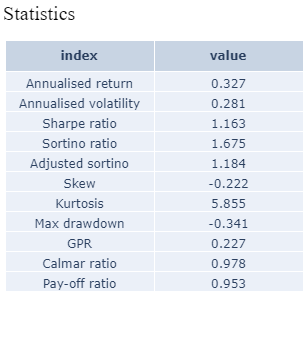

In [53]:
#transform pd. dataframe to image

fig = df2img.plot_dataframe(
    statistics.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Statistics"),
    fig_size=(308, 338),

   )

df2img.save_dataframe(fig=fig, filename='../img/temp/statistics_all_weather' + unique_name + '.png')

fig_stats = fig
#statistics.to_csv('./img/temp/statistics_all_weather' + unique_name + '.csv')

#### Drawdown and underwater plots:

In [157]:
###No need to be run###

# Create benchmark portfolio (classic 60/40)
benchmark_portf = hep.create_dataframe(['SPY', 'TLT']) #TLT
benchmark_portf.dropna(inplace = True)
benchmark_portf_perc = hep.return_df(benchmark_portf)
benchmark_portf_weight = pd.DataFrame()
benchmark_portf_weight['SPY'] = benchmark_portf_perc['SPY'] * 0.6
benchmark_portf_weight['TLT'] = benchmark_portf_perc['TLT'] * 0.4
benchmark_portf_weight['TOT'] = benchmark_portf_weight.sum(axis=1)
benchmark_portf_weight.dropna(inplace = True)
benchmark_earnings = hep.df_earnings(benchmark_portf_weight, benchmark_portf_perc)
benchmark_portf_perc['Tot'] = benchmark_portf_perc.sum(axis=1)
benchmark_portf_perc.dropna(inplace = True)
#benchmark_portf_perc = benchmark_portf_perc[-len(data_earnings):] #as big as the all weather one
benchmark_portf_perc = benchmark_portf_perc.loc[start_date: end_date] #as big as the all weather one
#data_earnings = benchmark_portf_perc

In [54]:
# Param
grayscale=True 
figsize= (10, 5.5)
fontname='Arial' 
lw=1
log_scale=False
match_volatility=False
compound=False
ylabel="Drawdown"
resample=None 
subtitle=True 
savefig =  '../img/temp/under_water_plot' + unique_name + '.png'
show=True

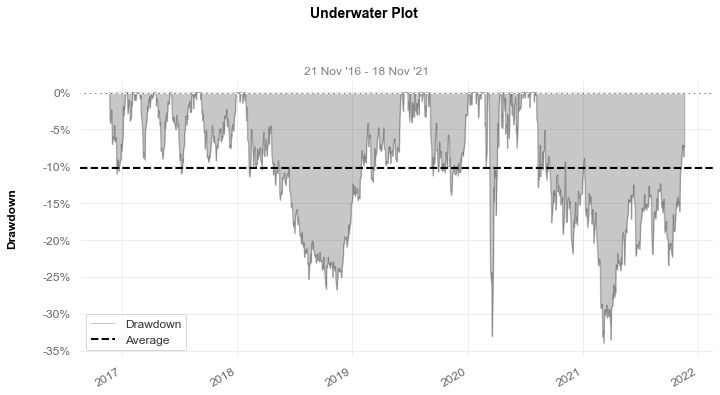

In [55]:
from quantstats._plotting.core import plot_timeseries

dd = to_drawdown_series(data_earnings['Tot'])
#bench_dd = to_drawdown_series(benchmark_portf_perc['TOT'])

fig = plot_timeseries(dd, title='Underwater Plot',
                            hline=dd.mean(), hlw=2, hllabel="Average",
                            returns_label="Drawdown",
                            compound=compound, match_volatility=match_volatility,
                            log_scale=log_scale, resample=resample,
                            fill=True, lw=lw, figsize=figsize,
                            ylabel=ylabel,
                            fontname=fontname, grayscale=grayscale,
                            subtitle=subtitle,
                            savefig=savefig, show=show)
fig

## Combine the plots and create a figure

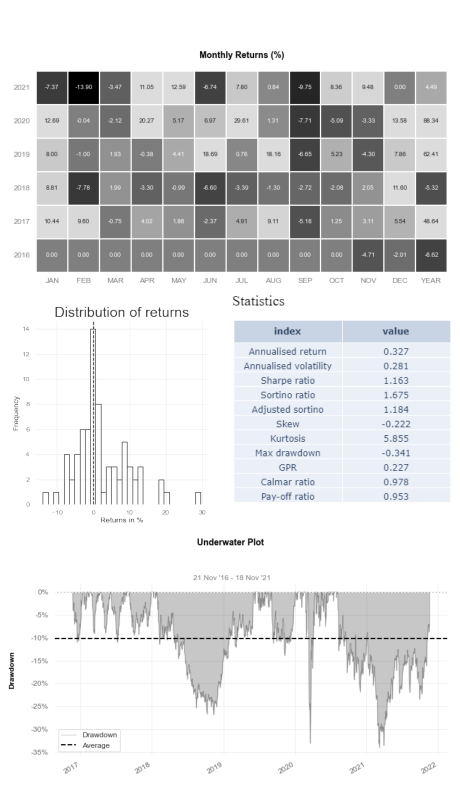

In [56]:
fig = plt.figure(figsize=(8, 13.55))

gs = gridspec.GridSpec(3, 2, wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0, :])
fig_table = plt.imread('../img/temp/table_montly_returns' + unique_name + '.png')
ax1.imshow(fig_table)
ax1.set_aspect('equal')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

ax2 = plt.subplot(gs[1,:1])
fig_distribiution = plt.imread('../img/temp/distribution_returns' + unique_name + '.png')
ax2.imshow(fig_distribiution)
ax2.set_aspect('equal')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(False)

ax3 = plt.subplot(gs[1, 1:])
fig_stats = plt.imread('../img/temp/statistics_all_weather' + unique_name + '.png')
ax3.imshow(fig_stats)
ax3.set_aspect('equal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.grid(False)
    
ax4 = plt.subplot(gs[-1,:])
fig_underwater = plt.imread('../img/temp/under_water_plot' + unique_name + '.png')
ax4.imshow(fig_underwater)
ax4.set_aspect('equal')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(False)

fig.suptitle(title, fontsize=25, y = 0.92, color = 'w') #add the correct leverage

plt.savefig('../reports/report_' + unique_name + '.png', dpi = 1200)

In [57]:
unique_name

'stdv_UPRO_TMF_IAU'